In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import BaggingRegressor
from joblib import dump, load

In [3]:
linear_model = load('data/model_linear.pkl')
svm_model = load('data/model_SVM.pkl')
rf_model = load('data/model_tree.pkl')


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Rieko00/psd/main/bmri_uni.csv')
df

,Tanggal,Pembukaan
0,11/10/2024,7025
1,10/10/2024,6925
2,09/10/2024,7075
3,08/10/2024,6825
4,07/10/2024,6925
...,...,...
1398,08/01/2019,7425
1399,07/01/2019,7500
1400,04/01/2019,7175
1401,03/01/2019,7275


In [5]:
df = df[['Tanggal', 'Pembukaan']]
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, format='%d/%m/%Y').dt.date
df.set_index('Tanggal', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [6]:
scaler = MinMaxScaler()
df['Pembukaan'] = scaler.fit_transform(df[['Pembukaan']])

In [7]:
df

,Pembukaan
Tanggal,
2019-01-02,0.859155
2019-01-03,0.835681
2019-01-04,0.816901
2019-01-07,0.877934
2019-01-08,0.863850
...,...
2024-10-07,0.769953
2024-10-08,0.751174
2024-10-09,0.798122


In [8]:
def sliding_window(data, lag):
    series = data['Pembukaan']
    result = pd.DataFrame()
    for l in lag:
        result[f'open-{l}'] = series.shift(l)

    result['open'] = series[l:]
    result = result.dropna()
    result.index = series.index[l:]
    return result

windowed_data = sliding_window(df, [1, 2, 3])
windowed_data = windowed_data[['open', 'open-1', 'open-2', 'open-3']]
print(windowed_data)

                open    open-1    open-2    open-3
Tanggal                                           
2019-01-07  0.877934  0.816901  0.835681  0.859155
2019-01-08  0.863850  0.877934  0.816901  0.835681
2019-01-09  0.877934  0.863850  0.877934  0.816901
2019-01-10  0.901408  0.877934  0.863850  0.877934
2019-01-11  0.924883  0.901408  0.877934  0.863850
...              ...       ...       ...       ...
2024-10-07  0.769953  0.788732  0.784038  0.788732
2024-10-08  0.751174  0.769953  0.788732  0.784038
2024-10-09  0.798122  0.751174  0.769953  0.788732
2024-10-10  0.769953  0.798122  0.751174  0.769953
2024-10-11  0.788732  0.769953  0.798122  0.751174

[1400 rows x 4 columns]


In [9]:
def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)

    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]

    return x_train, y_train, x_test, y_test

input_df = windowed_data[['open-1', 'open-2', 'open-3']]
target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.8)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1120, 3)
y_train shape: (1120, 1)
X_test shape: (280, 3)
y_test shape: (280, 1)


In [10]:
print(linear_model)

windowed_data = sliding_window(df, [1, 2, 3, 4])
windowed_data = windowed_data[['open', 'open-1', 'open-2', 'open-3', 'open-4']]

input_df = windowed_data[['open-1', 'open-2', 'open-3', 'open-4']]
target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.7)

linear_model.fit(x_train, y_train)

y_pred = linear_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

BaggingRegressor(estimator=LinearRegression())
Mean Squared Error (MSE): 0.0003758775005054677
Root Mean Squared Error (RMSE): 0.019387560457815926
Mean Absolute Percentage Error (MAPE): 2.4087667204768124 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


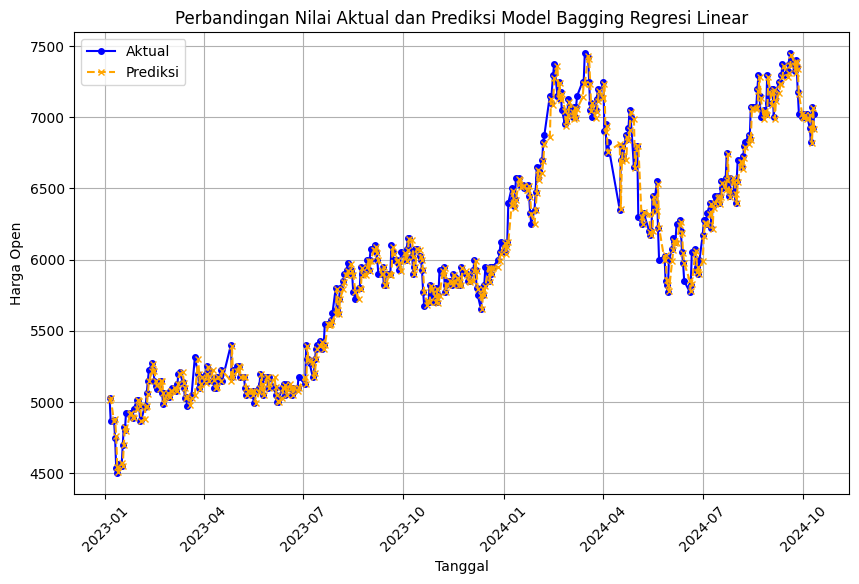

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Bagging Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [12]:
predict_lr = pd.DataFrame({
	'actual': scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten(),
	'predict': scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
})
predict_lr

,actual,predict
0,5025.0,5013.371692
1,4863.0,5024.672200
2,4875.0,4862.925083
3,4750.0,4877.482789
4,4538.0,4759.320265
...,...,...
415,6925.0,7013.188423
416,6825.0,6916.948382
417,7075.0,6817.544631
418,6925.0,7064.981617


In [13]:
predict_lr.to_excel('data/predict_lr.xlsx', index=False)

In [14]:
windowed_data = sliding_window(df, [1, 2, 3])
windowed_data = windowed_data[['open', 'open-1', 'open-2', 'open-3']]

input_df = windowed_data[['open-1', 'open-2', 'open-3']]
target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.7)

svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Mean Squared Error (MSE): 0.00036734844374423047
Root Mean Squared Error (RMSE): 0.01916633621076888
Mean Absolute Percentage Error (MAPE): 2.381986996546447 %


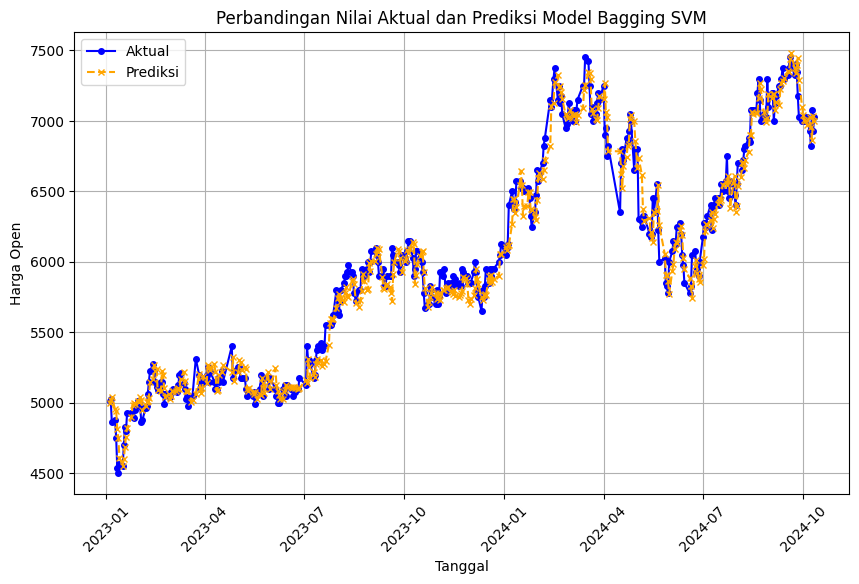

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Bagging SVM')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [16]:
predict_svm = pd.DataFrame({
	'actual': scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten(),
	'predict': scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
})
predict_svm

,actual,predict
0,5013.0,4937.543149
1,5025.0,5018.389573
2,4863.0,5023.756120
3,4875.0,4878.285953
4,4750.0,4895.186753
...,...,...
416,6925.0,7030.111639
417,6825.0,6942.268800
418,7075.0,6848.844551
419,6925.0,7058.803744


In [17]:
predict_svm.to_excel('data/predict_svm.xlsx', index=False)

In [18]:
windowed_data = sliding_window(df, [1, 2, 3])
windowed_data = windowed_data[['open', 'open-1', 'open-2', 'open-3']]

input_df = windowed_data[['open-1', 'open-2', 'open-3']]
target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.7)

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 0.00047880945749839444
Root Mean Squared Error (RMSE): 0.021881715140692114
Mean Absolute Percentage Error (MAPE): 2.8386498556195994 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


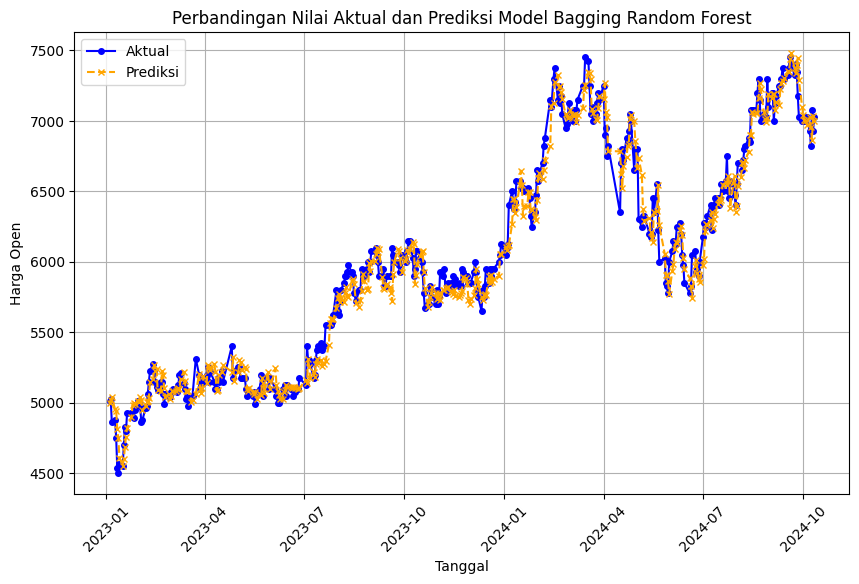

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Bagging Random Forest')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [20]:
predict_lr = pd.DataFrame({
	'actual': scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten(),
	'predict': scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
})
predict_lr

,actual,predict
0,5013.0,4995.89
1,5025.0,5018.81
2,4863.0,5038.38
3,4875.0,4952.92
4,4750.0,4943.89
...,...,...
416,6925.0,7027.00
417,6825.0,6953.50
418,7075.0,6867.00
419,6925.0,7035.50


In [21]:
predict_lr.to_excel('data/predict_rf.xlsx', index=False)